In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

/ssd_scratch/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
casestore = dict()

In [3]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [
    dict(name="base", id="x6a1-bbase_edgerecmaster", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    dict(name="fix", id="x6a1b-fix_anom_tflux", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),

]


for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                            double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                            unnormalise_geom = case["unnormalise_geom"])


CHECK: Total domain volume is 1.607E+00 [m3]
CHECK: Total domain volume is 1.607E+00 [m3]


# Convergence

In [ ]:
for casename in casestore.keys():
    print(casename)
    Monitor(casestore[casename], [
        # ["avg_density", "avg_temp", "target_temp","radiation"],
        ["sep_ne", "sep_te"],
        ["cvode_order", "cvode_ncalls_per_second", "cvode_linear_per_newton", "cumulative_linear_fails_per_second", "cumulative_newton_fails_per_second", "cvode_last_step"]
                ])

# Calculate anomalous heat flux through the sheath

In [21]:
# fig, ax = plt.subplots()
ds = casestore["fix"].ds 
m = ds.metadata

y_idx = {}
y_idx["il"] = 2
y_idx["iu"] = m["ny_inner"] + m["MYG"]
y_idx["ou"] = m["ny_inner"] + m["MYG"]*3 
y_idx["ol"] = -2
m = ds.metadata
anomflow = 0
norm = m["rho_s0"] * m["rho_s0"]**2 * m["Nnorm"] * m["Omega_ci"]
for side in ["il", "iu", "ou", "ol"]:
    region = ds.isel(theta=y_idx[side], t=-1)
    flow = region["ParticleFlow_d+_ylow"].sum()  * norm
    anomflow += abs(flow)
    print(f"{side}, {flow}")



il, 0.0
iu, 0.0
ou, 0.0
ol, 0.0


In [16]:
%matplotlib widget

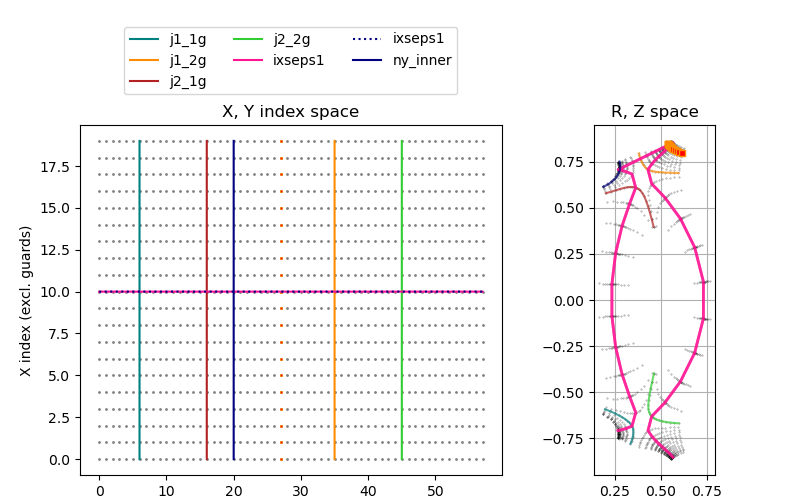

In [20]:
plt.close("all")
plot_selection(ds, ds.isel(theta=m["ny_inner"] + m["MYG"]*3 + 1))

In [10]:
data.dims

Frozen({'theta': 58})

Text(0.5, 1.0, 'D coefficient near target boundary')

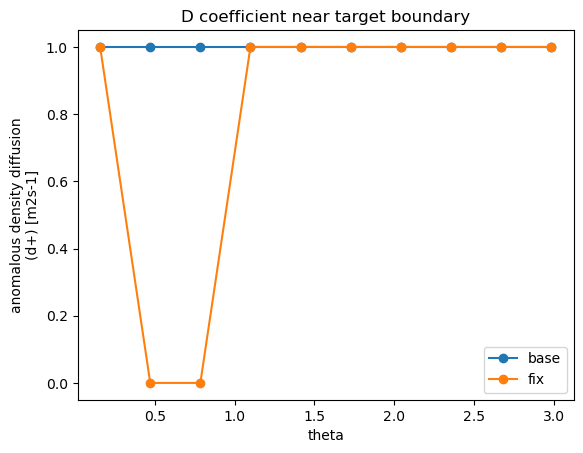

In [14]:


fig, ax = plt.subplots()

for case in ["base", "fix"]:
    ds = casestore[case].ds
    # data = ds.isel(theta=slice(-10,None), x=12, t = -1)
    data = ds.isel(theta=slice(0,10), x=12, t = -1)

    data["anomalous_D_d+"].plot(ax =ax, marker = "o", label = case)
    
ax.legend()
ax.set_title("D coefficient near target boundary")

Text(0.5, 1.0, 'Flux at lower Y boundary')

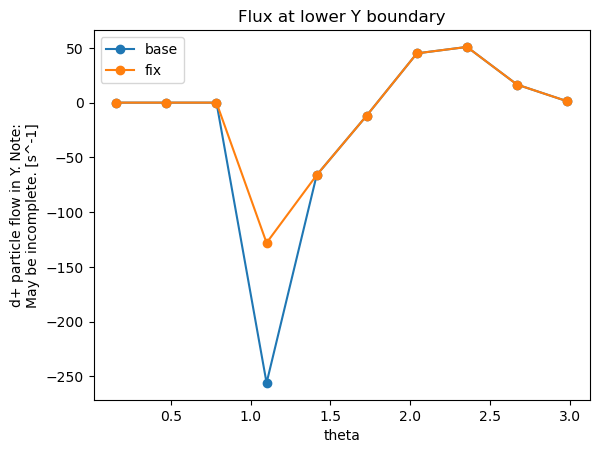

In [15]:
data = ds.isel(theta=slice(-10,None), x=12, t = -1)

fig, ax = plt.subplots()

for case in ["base", "fix"]:
    ds = casestore[case].ds
    # data = ds.isel(theta=slice(-10,None), x=12, t = -1)
    data = ds.isel(theta=slice(0,10), x=12, t = -1)

    data["ParticleFlow_d+_ylow"].plot(ax =ax, marker = "o", label = case)
    
ax.legend()
ax.set_title("Flux at lower Y boundary")

## Find saved variables

In [ ]:
ds = casestore["base"].ds
ds.data_vars

In [ ]:
fig, ax = plt.subplots(dpi = 150, figsize = (5,6))

fig.subplots_adjust(wspace=0.4)
ds = casestore["dev"].ds#.isel(t=-1)
m = ds.metadata
(ds["Sd_target_recycle"] * (m["Nnorm"] * m["Omega_ci"])).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r", vmax = 1e23, logscale = True)

ax.set_aspect("equal")
ax.set_ylim(-0.9, 0.2)

## Circumferential recycling plots

# Radial profiles for BC check

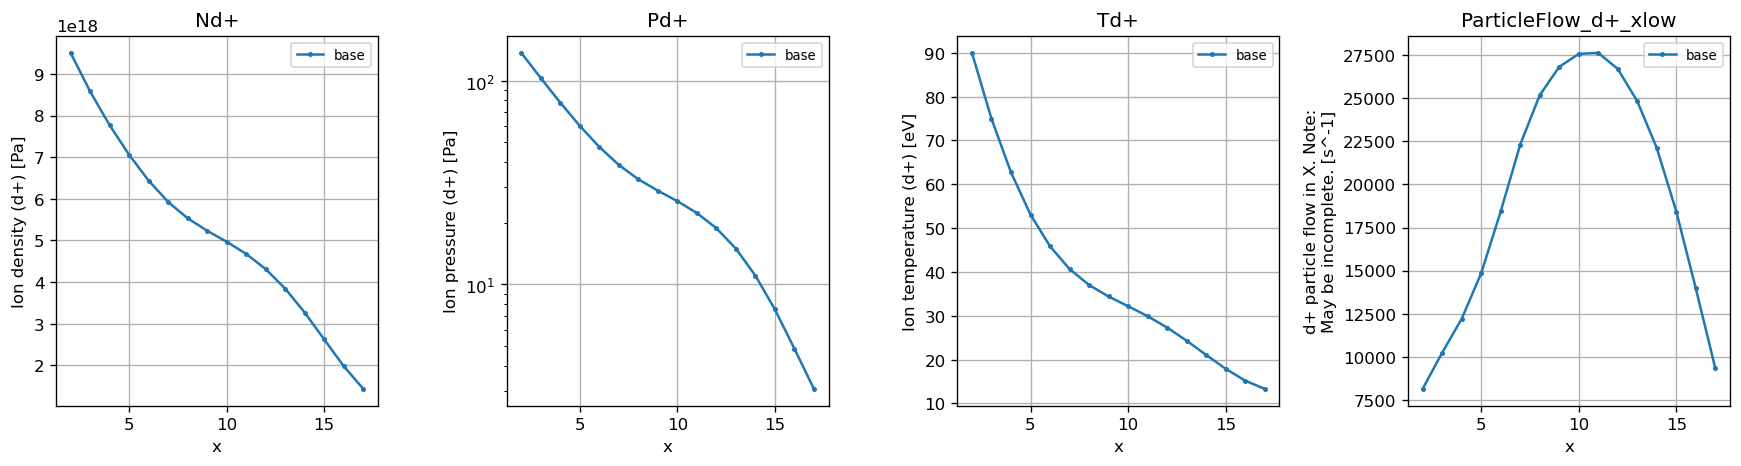

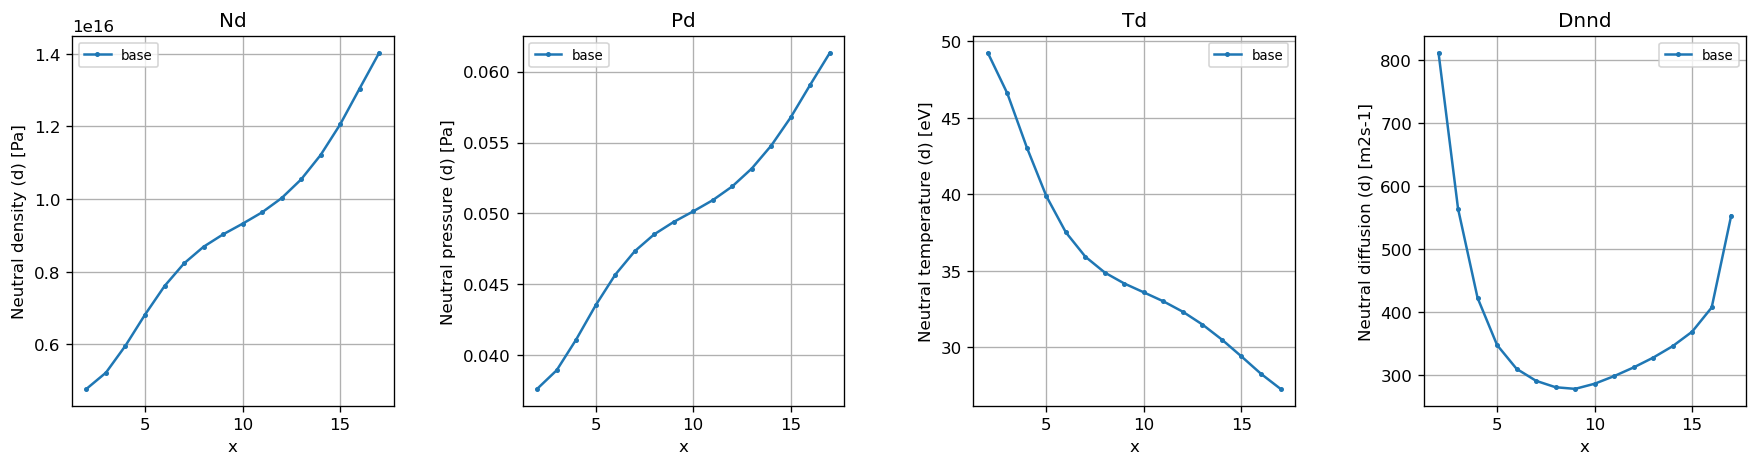

In [6]:
def plot(params):

    fig, axes = plt.subplots(1,len(params), figsize=(4.5*len(params),4), dpi=120)
    fig.subplots_adjust(wspace = 0.4)

    for i, param in enumerate(params):
        for casename in casestore:
            ds = casestore[casename].ds.isel(t=-1, x = slice(2,-2))
            omp = ds.hermesm.select_region("outer_midplane_a")

            (omp[param]).plot(ax = axes[i], marker = "o", label = casename, ms = 2)
            
            if omp[param].max()/omp[param].min() > 10:
                axes[i].set_yscale("log")
        axes[i].grid()
        axes[i].set_title(param)
        axes[i].legend(fontsize = 8)
   

plot(["Nd+", "Pd+", "Td+", "ParticleFlow_d+_xlow"])   
plot(["Nd", "Pd", "Td", "Dnnd"])  
# plot(["Nd", "Pd"])


In [ ]:
toplot = dict()
# case_sel = ["fit_nsep3", "factor"]
case_sel = casestore.keys()
for casename in case_sel:
    toplot[casename] = casestore[casename].ds

lineplot(
    toplot,
    # params = ["Ne", "Td+", "Pd+", "NVd+"],
    params = ["Ne", "Td+", "Nd", "Td"],
    regions = ["field_line", "omp", "outer_lower"],
    # regions = ["omp"],
    scale = "log",
    dpi = 100
)

# Heat and particle balances

### Calculate

In [11]:
for name in casestore:
    casestore[name].ds = calculate_radial_fluxes(casestore[name].ds, force_neumann = False)
    casestore[name].ds = calculate_target_fluxes(casestore[name].ds)
    # casestore[name].ds = calculate_heat_balance(casestore[name].ds)
    # casestore[name].ds = calculate_particle_balance(casestore[name].ds)

Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper


# New particle balance

In [12]:
ds = casestore["base"].ds

m = ds.metadata
    
core = ds.hermesm.select_region("core_edge")
sol = ds.hermesm.select_region("sol_edge")
pfr = ds.hermesm.select_region("pfr_edge")
domain = ds.hermesm.select_region("all_noguards").squeeze()
domain_volume = domain["dv"].values.sum()
vars = ds.data_vars

df = pd.DataFrame()
pf = dict()

# Radial and edge fluxes
# The summing is clunky but there's apparently no other way in Xarray!
net = dict()

for place in ["src", "core", "sol", "pfr"]:
    net[f"pf_int_{place}_net"] = 0

### Calculate all integrals of edge fluxes and sources
for species in m["ion_species"] + m["neutral_species"]:
    ds[f"pf_int_src_{species}"] = (domain[f"S{species}_src"] * domain["dv"]).sum(["x", "theta"]).squeeze()
    ds[f"pf_int_core_{species}"] = core[f"pf_perp_diff_L_{species}"].sum("theta").squeeze()
    ds[f"pf_int_sol_{species}"] = sol[f"pf_perp_diff_R_{species}"].sum("theta").squeeze() * -1 # Positive is going right, which is flowing OUT
    ds[f"pf_int_pfr_{species}"] = pfr[f"pf_perp_diff_L_{species}"].sum("theta").squeeze()

    # Add to net counter for each location
    for place in ["src", "core", "sol", "pfr"]:
        net[f"pf_int_{place}_net"] += ds[f"pf_int_{place}_{species}"]
    
### Calculate all integrals of recycling sources
for species in m["recycle_pair"].values():
    if f"S{species}_sol_recycle" in vars:
        ds[f"pf_int_recycle_sol_{species}"] = (domain[f"S{species}_sol_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
    if f"S{species}_pfr_recycle" in vars:
        ds[f"pf_int_recycle_pfr_{species}"] = (domain[f"S{species}_pfr_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
    if f"S{species}_target_recycle" in vars:
        ds[f"pf_int_recycle_target_{species}"] = (domain[f"S{species}_target_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
        
    # Add to net counters for each location apart from sources since there are no user set recycling sources
    # Also add to the targets net counter (recycling sources per target basis not done yet)
    for place in ["sol", "pfr", "targets"]:   # No recycling in core, but yes in targets
        if f"pf_int_recycle_{place}_{species}" in vars:
            net[f"pf_int_{place}_net"] += ds[f"pf_int_recycle_{place}_{species}"]
    
### Calculate integrals of target fluxes
# Initialise per-target net counter
for name in m["targets"]:
    target_name = f"{name}_target"
    net[target_name] = 0
net["targets"] = 0


for name in m["targets"]:
    target_name = f"{name}_target"
    ## Capture ion species (flux leaving model)
    for species in m["ion_species"]:
        # net[f"targets_{species}"] = 0 # TODO: Not sure why we need a net per species?
        ds[f"pf_int_{target_name}_{species}"] = ds[f"pf_{target_name}_{species}"].sum("x").squeeze()
        net[target_name] += ds[f"pf_int_{target_name}_{species}"]   # Ion flux
        # net[f"targets_{species}"] += ds[f"pf_int_{target_name}_{species}"] # TODO: Not sure why we need a net per species?
        
    ## Capture recycled species (sources entering model)
    for species in m["recycle_pair"].values():
        ds[f"pf_int_recycle_{target_name}_{species}"] = ds[f"pf_recycle_{target_name}_{species}"].sum("x").squeeze()
        net[target_name] += ds[f"pf_int_recycle_{target_name}_{species}"]   # Recycling flux
        
        
    # ds[f"pf_int_targets_{species}"] = net[f"targets_{species}"] # TODO: Not sure why we need a net per species?
        
# Get the all target net counter
# Put the net counters into the dataset
for name in m["targets"]:
    target_name = f"{name}_target"
    ds[f"pf_int_{target_name}_net"] = net[target_name]
    net["targets"] += net[target_name]
    
ds[f"pf_int_targets_net"] = net["targets"]


### Atomic reaction fluxes
for ion in m["ion_species"]:
    
    if f"S{ion}_iz" in domain.data_vars:
        neutral = ion.split("+")[0]
        ds[f"pf_int_iz_{ion}"] = (domain[f"S{ion}_iz"] * domain["dv"]).sum(["x", "theta"]).squeeze()
        ds[f"pf_int_iz_{neutral}"] = ds[f"pf_int_iz_{ion}"] * -1
    
    if f"S{ion}_rec" in domain.data_vars:
        ds[f"pf_int_rec_{ion}"] = (domain[f"S{ion}_rec"] * domain["dv"]).sum(["x", "theta"]).squeeze()
        ds[f"pf_int_rec_{neutral}"] = ds[f"pf_int_rec_{ion}"] * -1

# Note: no "net" ionisation or recombination since they net out to zero.

### Put the net sums in each location into the dataset
for place in list_places:
    ds[f"pf_int_{place}_net"] = net[f"pf_int_{place}_net"]
    
for name in m["targets"]:
    target_name = f"{name}_target"
    ds[f"pf_int_{target_name}_net"] = net[target_name]
    net["targets"] += net[target_name]
    
ds[f"pf_int_targets_net"] = net["targets"]

### Calculate the total net balance
ds[f"pf_int_total_net"] = \
    ds["pf_int_src_net"] + ds["pf_int_core_net"] + ds["pf_int_sol_net"] + ds["pf_int_pfr_net"] \
        + ds["pf_int_targets_net"]

ValueError: dimensions cannot change for in-place operations

In [12]:
net.keys()

dict_keys(['pf_int_src_net', 'pf_int_core_net', 'pf_int_sol_net', 'pf_int_pfr_net', 'inner_lower', 'outer_lower', 'inner_upper', 'outer_upper', 'targets', 'targets_d+'])

In [8]:
list_places.app

TypeError: can only concatenate list (not "str") to list

In [8]:
casestore["base"].ds.dims

Frozen({'t': 6, 'x': 20, 'theta': 58})

In [ ]:
df = pd.DataFrame()
df.index = ["source", "core", "sol", "sol recycle", "pfr", "pfr recycle", "targets", "targets recycle", "iz", "rec"]
m = ds.metadata

if f"pf_int_{m['targets'][0]}" in ds.data_vars:
    merge_targets = False
else:
    merge_targets = True

last = ds.isel(t=-1)
for species in m["ion_species"] + m["neutral_species"]:
    df.loc["source", species] = last[f"pf_int_src_{species}"]
    df.loc["core", species] = last[f"pf_int_core_{species}"]
    df.loc["sol", species] = last[f"pf_int_sol_{species}"]
    df.loc["pfr", species] = last[f"pf_int_pfr_{species}"]
    
for species in m["ion_species"]:
    if merge_targets is True:
        df.loc["targets", species] = last[f"pf_int_targets_{species}"]
    else:
        for target in m["targets"]:
            df.loc[target, species] = last[f"pf_int_{target}_{species}"]
    
for species in m["ion_species"] + m["neutral_species"]:
    if f"pf_int_iz_{species}" in last.keys():
        df.loc["iz", species] = last[f"pf_int_iz_{species}"]
    if f"pf_int_rec_{species}" in last.keys():
        df.loc["rec", species] = last[f"pf_int_rec_{species}"]
        
for species in m["recycle_pair"].values():
    if f"pf_int_recycle_sol_{species}" in vars:
        df.loc["sol recycle", species] = last[f"pf_int_recycle_sol_{species}"]
    if f"pf_int_recycle_pfr_{species}" in vars:
        df.loc["pfr recycle", species] = last[f"pf_int_recycle_pfr_{species}"]
    if f"pf_int_recycle_target_{species}" in vars:
        df.loc["targets recycle", species] = last[f"pf_int_recycle_target_{species}"]
    
df["total"] = df.sum(axis=1)
imbalance = df["total"].sum()
imbalance_frac = imbalance / (df["total"]["source"] + df["total"]["core"])

# print(f"Recycling fraction: {frec:.2%}")
print(f"Domain volume: {ds['dv'].sum():.3e} [m3]")
print(f"Particle imbalance: {imbalance:,.3e} [s-1]")
print(f"Particle imbalance as frac of core + source: {imbalance_frac:.2%}")
print("---------------------------------------")
print(f"Total fluxes in [s-1]:")

def styler(s):
        if abs(s) < 0.01 or pd.isna(s):
            c =  "color: lightgrey"
        else:
            c =  "color: black"

        return c
        
ts = df.copy().style.format("{:.2e}")
ts = ts.applymap(styler)
display(ts)

Domain volume: 1.607e+00 [m3]
Particle imbalance: -4.566e+19 [s-1]
Particle imbalance as frac of core + source: -14.84%
---------------------------------------
Total fluxes in [s-1]:


,d+,d,total
source,0.00e+00,0.00e+00,0.00e+00
core,3.08e+20,0.00e+00,3.08e+20
sol,-0.00e+00,-0.00e+00,0.00e+00
sol recycle,nan,nan,0.00e+00
pfr,0.00e+00,0.00e+00,0.00e+00
pfr recycle,nan,nan,0.00e+00
targets,-6.97e+21,nan,-6.97e+21
targets recycle,nan,6.62e+21,6.62e+21
iz,6.62e+21,-6.62e+21,0.00e+00
rec,-2.03e+18,2.03e+18,0.00e+00


# NEW FORMAT

In [13]:
def make_balance(ds):
    m = ds.metadata
        
    core = ds.hermesm.select_region("core_edge")
    sol = ds.hermesm.select_region("sol_edge")
    pfr = ds.hermesm.select_region("pfr_edge")
    domain = ds.hermesm.select_region("all_noguards").squeeze()
    domain_volume = domain["dv"].values.sum()
    variables = ds.data_vars

    ### Calculate all integrals of edge flows and sources
    for species in m["ion_species"] + m["neutral_species"]:
        ds[f"pf_int_src_{species}"] = (domain[f"S{species}_src"] * domain["dv"]).sum(["x", "theta"]).squeeze()
        ds[f"pf_int_core_{species}"] = core[f"pf_perp_diff_L_{species}"].sum("theta").squeeze()
        ds[f"pf_int_sol_{species}"] = sol[f"pf_perp_diff_R_{species}"].sum("theta").squeeze() * -1 # Positive is going right, which is flowing OUT
        ds[f"pf_int_pfr_{species}"] = pfr[f"pf_perp_diff_L_{species}"].sum("theta").squeeze()
        
    ### Calculate integrals of recycling at edges
    for species in m["recycle_pair"].values():
        
        ## SOL
        name = f"S{species}_sol_recycle"
        if name in variables:
            ds[f"pf_int_recycle_sol_{species}"] = (domain[f"S{species}_sol_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
        else:
            print(f"{name} not found")
            
        ## PFR
        name = f"S{species}_pfr_recycle"
        if name in variables:
            ds[f"pf_int_recycle_pfr_{species}"] = (domain[f"S{species}_pfr_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
        else:
            print(f"{name} not found")
            
    
    ### Calculate integrals of target flows       
    ## Capture ion species (flows leaving model)
    for species in m["ion_species"]:
        for target_name in m["targets"]:
            ds[f"pf_int_{target_name}_target_{species}"] = ds[f"pf_{target_name}_target_{species}"].sum("x").squeeze()
            
    ## Capture recycled species (sources entering model)
    for species in m["recycle_pair"].values():
        for target_name in m["targets"]:
            ds[f"pf_int_recycle_{target_name}_target_{species}"] = ds[f"pf_recycle_{target_name}_target_{species}"].sum("x").squeeze()

    ### Atomic reaction flows
    for ion in m["ion_species"]:
        
        name = f"S{ion}_iz"
        if name in variables:
            neutral = ion.split("+")[0]
            ds[f"pf_int_iz_{ion}"] = (domain[f"S{ion}_iz"] * domain["dv"]).sum(["x", "theta"]).squeeze()
            ds[f"pf_int_iz_{neutral}"] = ds[f"pf_int_iz_{ion}"] * -1
        else:
            print(f"{name} not found")
        
        name = f"S{ion}_rec"
        if name in variables:
            ds[f"pf_int_rec_{ion}"] = (domain[f"S{ion}_rec"] * domain["dv"]).sum(["x", "theta"]).squeeze()
            ds[f"pf_int_rec_{neutral}"] = ds[f"pf_int_rec_{ion}"] * -1
        else:
            print(f"{name} not found")
            
    return ds

    
# Recycling from targets
# for species in m["recycle_pair"].values():
#     for target_name in m["targets"]:
#         kind = target_name + "_target"
#         name = f"pf_int_recycle_{target_name}_target_{species}"
#         if name in variables:
#             net[f"{kind}"] += ds[name]

def sum_balances(ds):
    """
    Sums flows for all species
    """
    variables = ds.data_vars
    m = ds.metadata
    
    ### Calculate totals per location/source, no matter what the species
    net = dict()
    ## Regular sources and edges
    for kind in ["src", "core", "sol", "pfr"]:
        net[kind] = 0
        for species in m["ion_species"] + m["neutral_species"]:
            net[kind] += ds[f"pf_int_{kind}_{species}"]

    ## Recycling from edges
    for kind in ["recycle_sol", "recycle_pfr"]:
        net[kind] = 0
        for species in m["recycle_pair"].values():
            name = f"pf_int_{kind}_{species}"
            if name in variables:
                net[kind] += ds[name]
            else:
                print(f"{name} not found")
                
    ## Reactions are not a net particle sink or source so are not included
            
    ## Targets
    # Flows in or out of targets
    for target_name in m["targets"]:
        kind = f"{target_name}_target"
        net[f"{kind}"] = 0
        
        for species in m["ion_species"]:
            name = f"pf_int_{kind}_{species}"
            
            if name in variables:
                net[f"{kind}"] += ds[name]
            else:
                print(f"{name} not found")
                
    # Recycling from targets         
    for target_name in m["targets"]:
        kind = f"recycle_{target_name}_target"
        net[f"{kind}"] = 0
        
        for species in m["recycle_pair"].values():
            name = f"pf_int_{kind}_{species}"
            
            if name in variables:
                net[f"{kind}"] += ds[name]
            else:
                print(f"{name} not found")
                
    ## Sum targets
    net["targets"] = 0
    net["recycle_targets"] = 0

    for target_name in m["targets"]:
        net["targets"] += net[f"{target_name}_target"]
        net["recycle_targets"] += net[f"recycle_{target_name}_target"]

    net["targets_net"] = net["targets"] + net["recycle_targets"]
    
    return net

In [24]:
ds["pf_int_inner_lower_target_d+"].dims

('t',)

In [14]:
ds = casestore["base"].ds
ds = make_balance(ds)
net = sum_balances(ds)

Sd_sol_recycle not found
Sd_pfr_recycle not found
pf_int_recycle_sol_d not found
pf_int_recycle_pfr_d not found


In [16]:
place

'targets_net'

In [22]:
net["recycle_targets"].isel(t=-1)

<xarray.DataArray 'pf_int_recycle_inner_lower_target_d' (theta: 58)>
dask.array<getitem, shape=(58,), dtype=float64, chunksize=(58,), chunktype=numpy.ndarray>
Coordinates:
    t          float64 0.1675
  * theta      (theta) float64 0.1571 0.4712 0.7854 1.1 ... 17.44 17.75 18.06
    zeta       float64 3.142
    theta_idx  (theta) int64 0 1 2 3 4 5 6 7 8 9 ... 49 50 51 52 53 54 55 56 57
Attributes:
    current_time_index:  546
    cell_location:       CELL_CENTRE
    conversion:          9.578833303066081e+24
    direction_y:         Standard
    direction_z:         Standard
    long_name:           Target recycling neutral density source (d)
    source:              recycling
    standard_name:       Target recycle neutral density source (d)
    time_dimension:      t
    units:               m-3s-1
    metadata:            {'BOUT_VERSION': 5.01, 'Bnorm': 1.0, 'Cs0': 97871.51...
    options:             # Test case with constant fast anomalous diffusion, ...
    regions:             {'lower_inner_PFR': <xbout.region.Region>\n\tname\tl...
    geometry:            toroidal

In [15]:
df = pd.DataFrame()
# df.index = ["src", "core", "sol", "sol recycle", "pfr", "pfr recycle", "net_targets"]
m = ds.metadata
balance = 0

for place in ["src", "core", "sol", "recycle_sol", "pfr", "recycle_pfr", "targets_net"]:
    if not isinstance(net[place], int):
        df.loc[place, "Value"] = net[place].isel(t=-1)
        balance += net[place]
    
display(df)
print(f"Sum: {df.sum()}")
print(f"With anomalous flow: {df.values.sum() + anomflow}")

ValueError: setting an array element with a sequence.